In [11]:
# Cell 1 - Imports
import getpass
import os
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langchain_core.messages import HumanMessage
from langchain_anthropic import ChatAnthropic

from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

from IPython.display import Image, display
import json
from pprint import pprint

In [2]:
# Cell 2 - Initialize tools and LLM
tavily_tool = TavilySearchResults(max_results=5)
repl = PythonREPL()
llm = ChatAnthropic(model="claude-3-5-sonnet-latest")

In [3]:
# Cell 3 - Define tools and helper functions
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

def _set_if_undefined(var: str):
    """Set the environment variable if it is not already set."""
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [5]:
# Cell 4 - Define node functions
def research_node(state: MessagesState) -> MessagesState:
    result = research_agent.invoke(state)
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return {
        "messages": result["messages"],
    }

def chart_node(state: MessagesState) -> MessagesState:
    result = chart_agent.invoke(state)
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return {
        "messages": result["messages"],
    }

def router(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if "FINAL ANSWER" in last_message.content:
        return END
    return "continue"

In [7]:
# Cell 5 - Set up environment and agents
_set_if_undefined("TAVILY_API_KEY")
_set_if_undefined("ANTHROPIC_API_KEY")

research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    state_modifier=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)

chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    state_modifier=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)

In [8]:
# Cell 6 - Create and configure workflow
workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_conditional_edges(
    "researcher",
    router,
    {"continue": "chart_generator", END: END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "researcher", END: END},
)

workflow.add_edge(START, "researcher")
graph = workflow.compile()

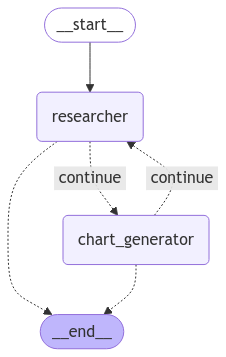


=== New State ===
{ 'researcher': { 'messages': [ { 'content': "First, get the UK's GDP over the "
                                             'past 5 years, then make a line '
                                             'chart of it. Once you make the '
                                             'chart, finish.',
                                  'name': None,
                                  'type': 'HumanMessage'},
                                { 'content': [ { 'text': "I'll help research "
                                                         "the UK's GDP data "
                                                         'for the past 5 '
                                                         'years. Let me search '
                                                         'for this '
                                                         'information.',
                                                 'type': 'text'},
                                               { 'i

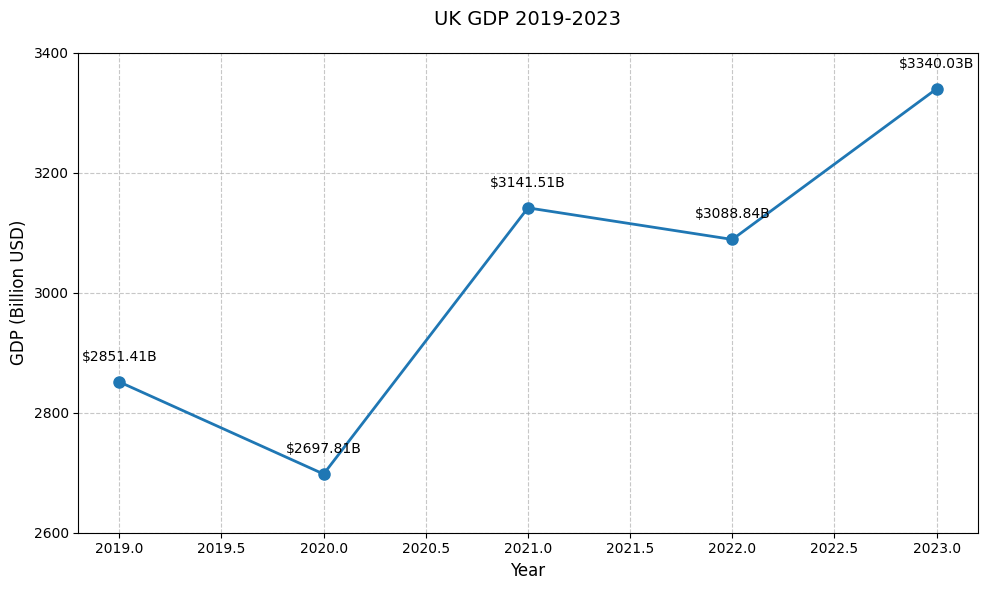


=== New State ===
{ 'chart_generator': { 'messages': [ { 'content': "First, get the UK's GDP "
                                                  'over the past 5 years, then '
                                                  'make a line chart of it. '
                                                  'Once you make the chart, '
                                                  'finish.',
                                       'name': None,
                                       'type': 'HumanMessage'},
                                     { 'content': [ { 'text': "I'll help "
                                                              'research the '
                                                              "UK's GDP data "
                                                              'for the past 5 '
                                                              'years. Let me '
                                                              'search for this '
                 

In [12]:
# Cell 7 - Display graph and run workflow
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

events = graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get the UK's GDP over the past 5 years, then make a line chart of it. "
                "Once you make the chart, finish.",
            )
        ],
    },
    {"recursion_limit": 150},
)


for s in events:
    # Convert the state to a more readable format
    readable_state = {
        node: {
            "messages": [
                {
                    "type": type(msg).__name__,
                    "content": msg.content,
                    "name": getattr(msg, "name", None)
                }
                for msg in state["messages"]
            ]
        }
        for node, state in s.items()
    }
    
    print("\n=== New State ===")
    pprint(readable_state, indent=2, width=80)
    print("\n" + "="*50 + "\n")